In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from __future__ import print_function, division
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

# Add src to path
import sys
sys.path.append('../src')

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.13.0
Torchvision Version: 0.14.0
GPU is available? True


## Read Data

In [3]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert to tensor and scale to [0, 1]
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

In [4]:
N = len(mnist_trainset)
N_test = len(mnist_testset)

x_train = torch.stack([data[0] for data in mnist_trainset][:N]).reshape(len(mnist_trainset), -1)
y_train = torch.LongTensor([data[1] for data in mnist_trainset][:N])
x_test = torch.stack([data[0] for data in mnist_testset][:N_test]).reshape(len(mnist_testset), -1)
y_test = torch.LongTensor([data[1] for data in mnist_testset][:N_test])

print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

x_train.shape: torch.Size([60000, 784])
y_train.shape: torch.Size([60000])
x_test.shape: torch.Size([10000, 784])
y_test.shape: torch.Size([10000])


## Block Coordinate Descent

In [12]:
from bcd import ThreeSplitBCD

bcd_runner = ThreeSplitBCD((x_train,y_train), (x_test,y_test), K=10, batch_size=N, device=device, seed=42)


In [13]:
results_bcd = bcd_runner.train(niter=1, niter_inner=50, log_inner=True, shuffle=False, verbose=True)

Inner Iter 1 / 50 
 - time: 1.6119980812072754 - sq_loss: 20393.6015625 - tot_loss: 20422.1788835536 - acc: 0.1945 - val_acc: 0.1944
Inner Iter 2 / 50 
 - time: 2.9254982471466064 - sq_loss: 15402.1416015625 - tot_loss: 15413.216659454047 - acc: 0.6511166666666667 - val_acc: 0.6603
Inner Iter 3 / 50 
 - time: 4.223497152328491 - sq_loss: 11835.8916015625 - tot_loss: 11842.046979277395 - acc: 0.8541833333333333 - val_acc: 0.8588
Inner Iter 4 / 50 
 - time: 5.50999641418457 - sq_loss: 9153.5859375 - tot_loss: 9159.017280346248 - acc: 0.8958333333333334 - val_acc: 0.8982
Inner Iter 5 / 50 
 - time: 6.800496578216553 - sq_loss: 7094.52294921875 - tot_loss: 7099.625288181007 - acc: 0.9110166666666667 - val_acc: 0.9104
Inner Iter 6 / 50 
 - time: 8.093995809555054 - sq_loss: 5502.24755859375 - tot_loss: 5507.782183798961 - acc: 0.9180333333333334 - val_acc: 0.9182
Inner Iter 7 / 50 
 - time: 9.382495164871216 - sq_loss: 4267.890625 - tot_loss: 4272.449337145314 - acc: 0.9227 - val_acc: 0.921

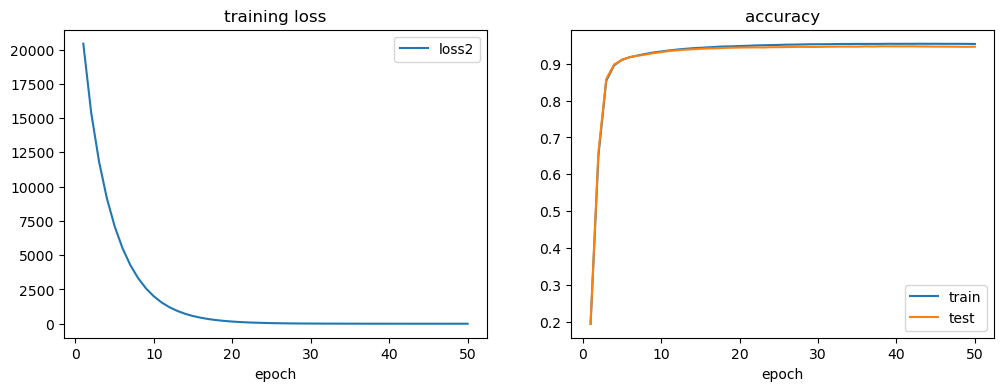

In [21]:
# retrieve results
results = results_bcd[1]


def plot_results_bcd(results, xlabel='epoch'):
    loss1, loss2 = results['loss1'], results['loss2']
    accuracy_train, accuracy_test = results['acc_tr'], results['acc_te']

    niter=len(loss1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(np.arange(1,niter+1), loss2, label='loss2')
    plt.title('training loss')
    plt.xlabel(xlabel)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(1,niter+1), accuracy_train, label='train')
    plt.plot(np.arange(1,niter+1), accuracy_test, label='test')
    plt.title('accuracy')
    plt.xlabel(xlabel)
    plt.legend()

plot_results_bcd(results)
plt.show()

In [24]:
K = 10
batch_size = 64
num_iter = 200
niter_inner = 30

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=False, shuffle=True, verbose=10)

# Save results
save_path = '../results/bcd_b64_o200_i30.json'
with open(save_path, 'w') as f:
    json.dump(results, f)



Iter 10 / 200 
 - time: 2.898545503616333 - sq_loss: 1.7543763676037392 - tot_loss: 1.7802760248499252 - acc: 0.95 - val_acc: 0.7886900000000001
Iter 20 / 200 
 - time: 2.9049510955810547 - sq_loss: 1.7440042187149325 - tot_loss: 1.7573523068658257 - acc: 0.9552083333333333 - val_acc: 0.8199400000000002
Iter 30 / 200 
 - time: 2.7934579849243164 - sq_loss: 2.0338744649042684 - tot_loss: 2.0448412579825304 - acc: 0.9213541666666667 - val_acc: 0.8453566666666669
Iter 40 / 200 
 - time: 2.797044515609741 - sq_loss: 1.4264926511173448 - tot_loss: 1.4333927739646677 - acc: 0.9697916666666667 - val_acc: 0.85593
Iter 50 / 200 
 - time: 2.8149285316467285 - sq_loss: 1.7414708334331712 - tot_loss: 1.7485063216930208 - acc: 0.9364583333333333 - val_acc: 0.8502100000000001
Iter 60 / 200 
 - time: 2.8041887283325195 - sq_loss: 1.1979136840750775 - tot_loss: 1.2016932380006606 - acc: 0.9796875 - val_acc: 0.87983
Iter 70 / 200 
 - time: 2.892036199569702 - sq_loss: 1.3992109735806784 - tot_loss: 1.4

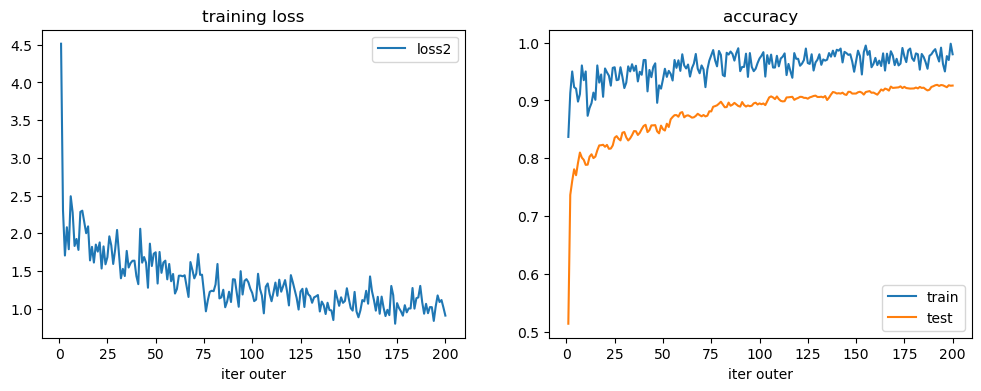

In [29]:
# Load results from file
save_path = '../results/bcd_b64_o200_i30.json'
with open(save_path, 'r') as f:
    results = json.load(f)

plot_results_bcd(results, xlabel='iter outer')

In [26]:
K = 10
batch_size = 64
num_iter = 100
niter_inner = 60

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=False, shuffle=True, verbose=10)

# Save results
save_path = '../results/bcd_b64_o100_i60.json'
with open(save_path, 'w') as f:
    json.dump(results, f)


Iter 10 / 100 
 - time: 5.605461835861206 - sq_loss: 1.3360764054911367 - tot_loss: 1.353966334422728 - acc: 0.9458333333333333 - val_acc: 0.72648
Iter 20 / 100 
 - time: 5.590924978256226 - sq_loss: 1.0737626527882336 - tot_loss: 1.0828644309442188 - acc: 0.96640625 - val_acc: 0.7863450000000002
Iter 30 / 100 
 - time: 5.646451234817505 - sq_loss: 1.1048608969460474 - tot_loss: 1.1119919490859584 - acc: 0.9671875 - val_acc: 0.8080916666666667
Iter 40 / 100 
 - time: 5.747492551803589 - sq_loss: 0.8795890696967642 - tot_loss: 0.885130122297166 - acc: 0.9736979166666667 - val_acc: 0.8195783333333337
Iter 50 / 100 
 - time: 5.8509979248046875 - sq_loss: 0.8581693496671505 - tot_loss: 0.8632527708747953 - acc: 0.9703125 - val_acc: 0.8440216666666664
Iter 60 / 100 
 - time: 5.848536968231201 - sq_loss: 0.8546445042675865 - tot_loss: 0.8592556196518338 - acc: 0.97421875 - val_acc: 0.8564183333333334
Iter 70 / 100 
 - time: 5.859071731567383 - sq_loss: 0.643581054831399 - tot_loss: 0.6469766

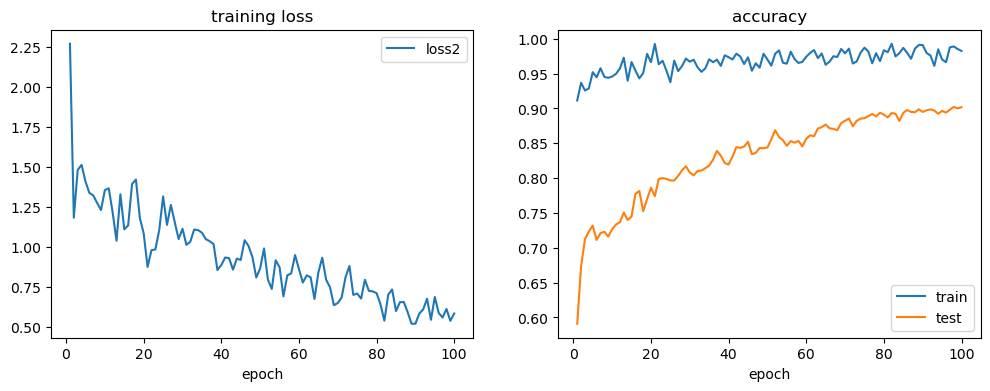

In [27]:
plot_results_bcd(results)

In [84]:
K = 10
batch_size = 64
num_iter = 50
niter_inner = 120
save_path = '../results/bcd_b64_o50_i120'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)


Inner Iter 10 / 120 
 - time: 1.220458984375 - sq_loss: 3.769827365875244 - tot_loss: 4.624582320545926 - acc: 0.90625 - val_acc: 0.6178
Inner Iter 20 / 120 
 - time: 2.2085015773773193 - sq_loss: 1.0616170167922974 - tot_loss: 1.3237558136102052 - acc: 1.0 - val_acc: 0.6573
Inner Iter 30 / 120 
 - time: 3.200465202331543 - sq_loss: 0.2771950364112854 - tot_loss: 0.36452639801564146 - acc: 1.0 - val_acc: 0.6685
Inner Iter 40 / 120 
 - time: 4.180465936660767 - sq_loss: 0.07464996725320816 - tot_loss: 0.10765453640215128 - acc: 1.0 - val_acc: 0.6627
Inner Iter 50 / 120 
 - time: 5.156917333602905 - sq_loss: 0.022503361105918884 - tot_loss: 0.03643768847814499 - acc: 1.0 - val_acc: 0.6605
Inner Iter 60 / 120 
 - time: 6.136372089385986 - sq_loss: 0.007874719798564911 - tot_loss: 0.01431355190402428 - acc: 1.0 - val_acc: 0.6564
Inner Iter 70 / 120 
 - time: 7.115412712097168 - sq_loss: 0.0031864738557487726 - tot_loss: 0.006376309152528847 - acc: 1.0 - val_acc: 0.6534
Inner Iter 80 / 120 

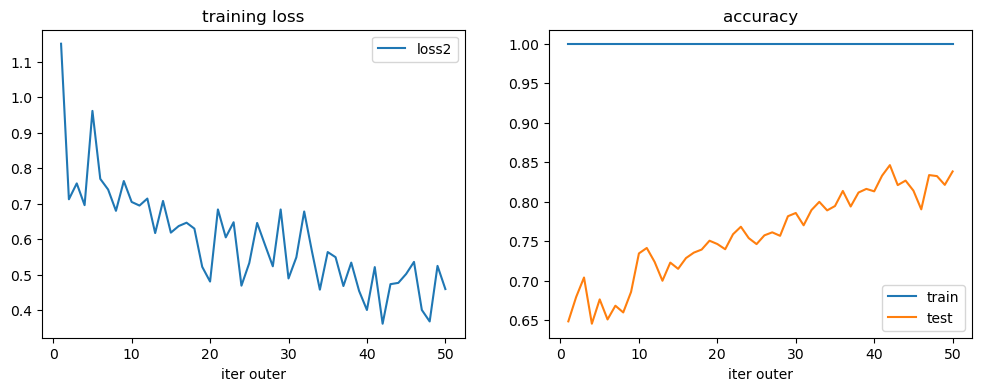

In [85]:
# Load results from file
save_path = '../results/bcd_b64_o50_i120.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results, xlabel='iter outer')

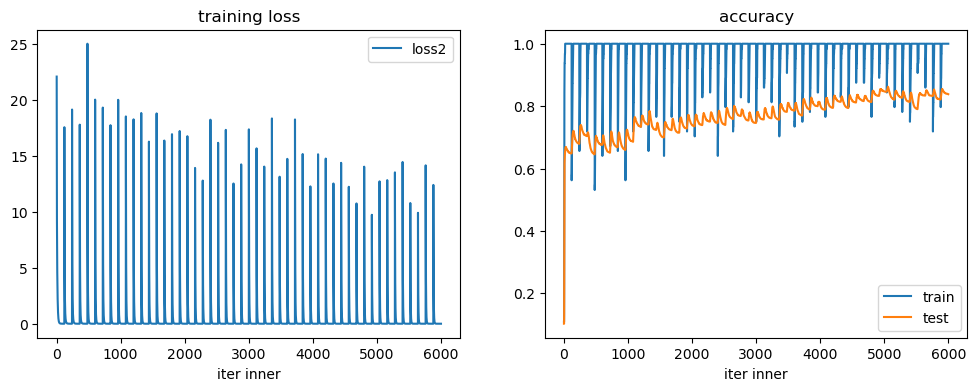

In [86]:
# Load results from file
save_path = '../results/bcd_b64_o50_i120_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='iter inner')

In [81]:
K = 10
batch_size = 128
num_iter = 300
niter_inner = 10
save_path = '../results/bcd_b128_o300_i10'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=9)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=10)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 10 
 - time: 1.0969626903533936 - sq_loss: 6.982390880584717 - tot_loss: 7.983333064389626 - acc: 0.921875 - val_acc: 0.6901
Inner Iter 10 / 10 
 - time: 0.9919993877410889 - sq_loss: 4.411852836608887 - tot_loss: 4.85429172777549 - acc: 0.9140625 - val_acc: 0.7649
Inner Iter 10 / 10 
 - time: 0.9899988174438477 - sq_loss: 3.2811787128448486 - tot_loss: 3.5546919299940782 - acc: 0.9140625 - val_acc: 0.7919
Inner Iter 10 / 10 
 - time: 0.987499475479126 - sq_loss: 2.81306529045105 - tot_loss: 3.0103029469855755 - acc: 0.9140625 - val_acc: 0.8182
Inner Iter 10 / 10 
 - time: 0.9774999618530273 - sq_loss: 2.3934884071350098 - tot_loss: 2.5464951121261947 - acc: 0.921875 - val_acc: 0.8199
Inner Iter 10 / 10 
 - time: 0.9755001068115234 - sq_loss: 2.226975440979004 - tot_loss: 2.349967101301445 - acc: 0.953125 - val_acc: 0.8286
Inner Iter 10 / 10 
 - time: 0.9734981060028076 - sq_loss: 2.402951240539551 - tot_loss: 2.5213826243079893 - acc: 0.8984375 - val_acc: 0.8343
Inner 

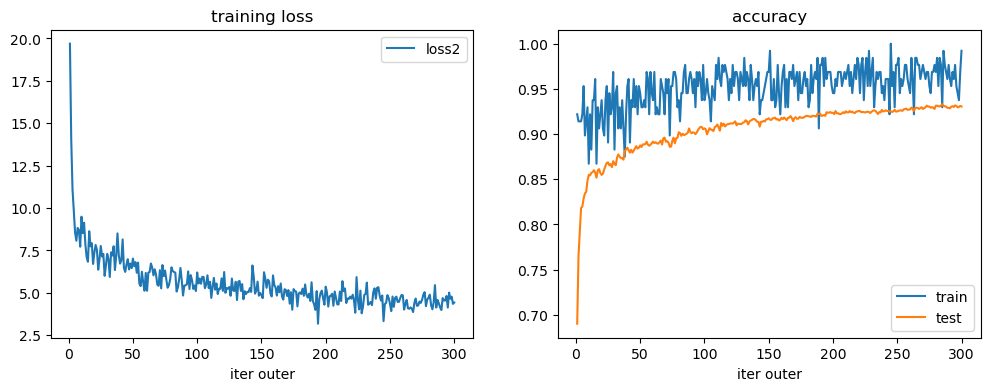

In [82]:
# Load results from file
save_path = '../results/bcd_b128_o300_i10.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results, xlabel='iter outer')

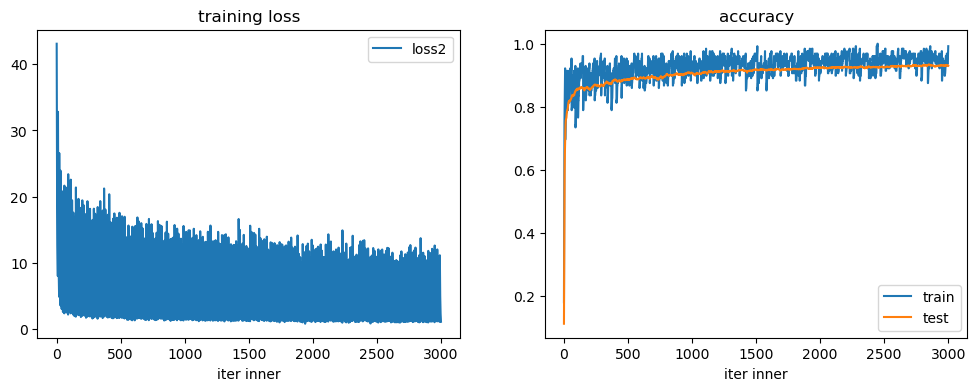

In [83]:
# Load results from file
save_path = '../results/bcd_b128_o300_i10_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='iter inner')

In [121]:
K = 10
batch_size = 128
num_iter = 100
niter_inner = 30
save_path = '../results/bcd_b128_o100_i30'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=False)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)


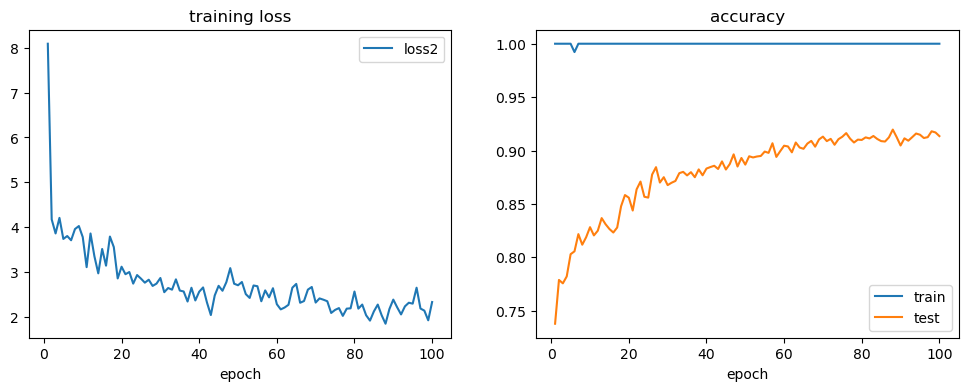

In [125]:
# Load results from file
save_path = '../results/bcd_b128_o100_i30.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

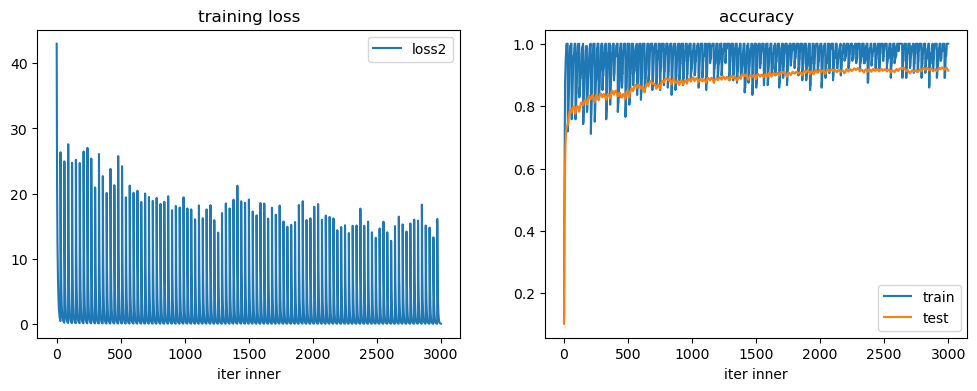

In [126]:
# Load results from file
save_path = '../results/bcd_b128_o100_i30_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='iter inner')

In [77]:
K = 10
batch_size = 128
num_iter = 200
niter_inner = 15
save_path = '../results/bcd_b128_o200_i15'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=10)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 15 
 - time: 1.1314971446990967 - sq_loss: 6.9574294090271 - tot_loss: 7.92206498072801 - acc: 0.8828125 - val_acc: 0.6532
Inner Iter 10 / 15 
 - time: 0.9914965629577637 - sq_loss: 3.469486951828003 - tot_loss: 3.7540939279706436 - acc: 0.9140625 - val_acc: 0.771
Inner Iter 10 / 15 
 - time: 1.0004985332489014 - sq_loss: 2.648627996444702 - tot_loss: 2.812380861868405 - acc: 0.9140625 - val_acc: 0.8131
Inner Iter 10 / 15 
 - time: 0.9854555130004883 - sq_loss: 2.482210636138916 - tot_loss: 2.609470341625638 - acc: 0.8671875 - val_acc: 0.8293
Inner Iter 10 / 15 
 - time: 0.9730014801025391 - sq_loss: 2.4596619606018066 - tot_loss: 2.56588498589781 - acc: 0.859375 - val_acc: 0.8382
Inner Iter 10 / 15 
 - time: 0.975956916809082 - sq_loss: 2.2627108097076416 - tot_loss: 2.3515276613106835 - acc: 0.890625 - val_acc: 0.8432
Inner Iter 10 / 15 
 - time: 0.9699623584747314 - sq_loss: 2.2804243564605713 - tot_loss: 2.3589375814976847 - acc: 0.8828125 - val_acc: 0.8416
Inner It

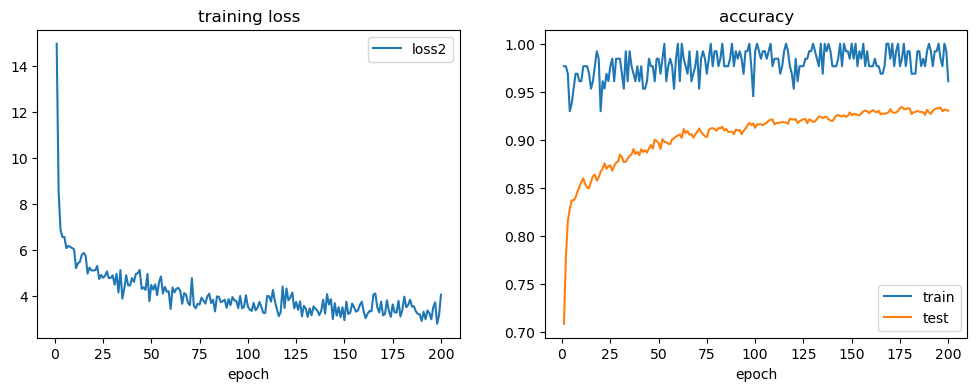

In [78]:
# Load results from file
save_path = '../results/bcd_b128_o200_i15.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

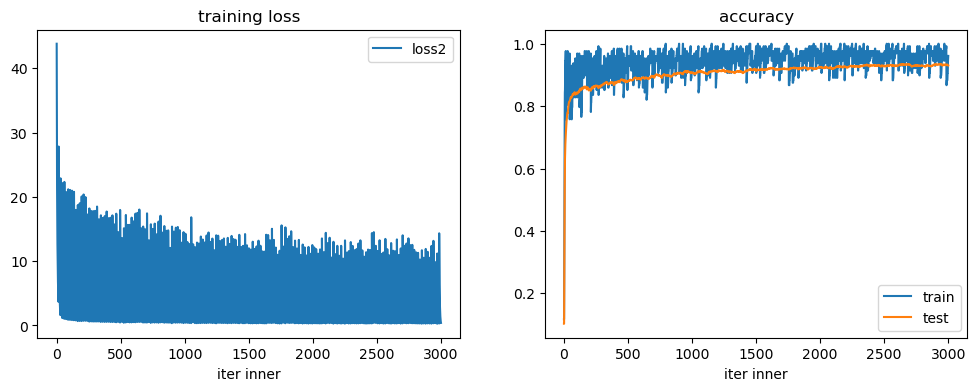

In [80]:
# Load results from file
save_path = '../results/bcd_b128_o200_i15_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='iter inner')

In [ ]:
K = 10
batch_size = 128
num_iter = 50
niter_inner = 60
save_path = '../results/bcd_b128_o50_i60'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

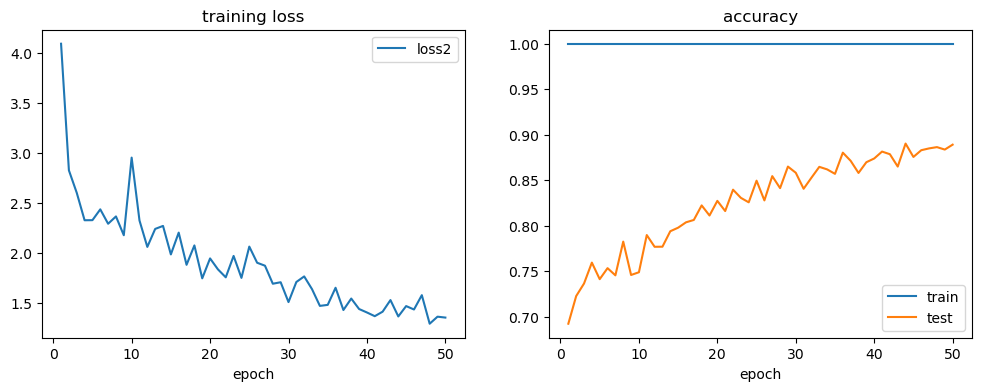

In [75]:
# Load results from file
save_path = '../results/bcd_b128_o50_i60.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

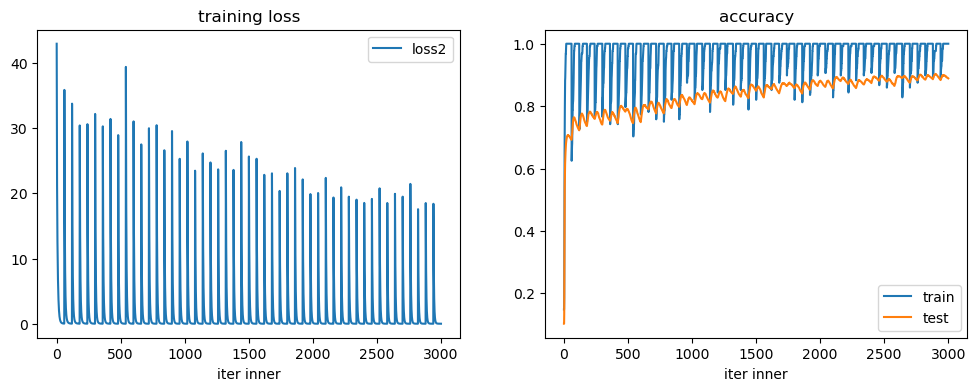

In [76]:
# Load results from file
save_path = '../results/bcd_b128_o50_i60_inner.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results, xlabel='iter inner')

In [60]:
K = 10
batch_size = 256
num_iter = 100
niter_inner = 15
save_path = '../results/bcd_b256_o100_i15'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=10)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 15 
 - time: 1.0585017204284668 - sq_loss: 12.858933448791504 - tot_loss: 13.882061799815347 - acc: 0.91796875 - val_acc: 0.7533
Inner Iter 10 / 15 
 - time: 1.0200004577636719 - sq_loss: 5.632184982299805 - tot_loss: 5.950553161994321 - acc: 0.8984375 - val_acc: 0.8098
Inner Iter 10 / 15 
 - time: 0.9920001029968262 - sq_loss: 4.334066867828369 - tot_loss: 4.518409611857351 - acc: 0.89453125 - val_acc: 0.8281
Inner Iter 10 / 15 
 - time: 1.002997636795044 - sq_loss: 4.738554954528809 - tot_loss: 4.898965234591742 - acc: 0.859375 - val_acc: 0.8553
Inner Iter 10 / 15 
 - time: 0.9990026950836182 - sq_loss: 3.929333448410034 - tot_loss: 4.039847660478699 - acc: 0.9296875 - val_acc: 0.8583
Inner Iter 10 / 15 
 - time: 0.9869992733001709 - sq_loss: 3.9480016231536865 - tot_loss: 4.04606549032178 - acc: 0.91015625 - val_acc: 0.863
Inner Iter 10 / 15 
 - time: 0.9849984645843506 - sq_loss: 3.8249330520629883 - tot_loss: 3.9096071187614143 - acc: 0.9140625 - val_acc: 0.8633
In

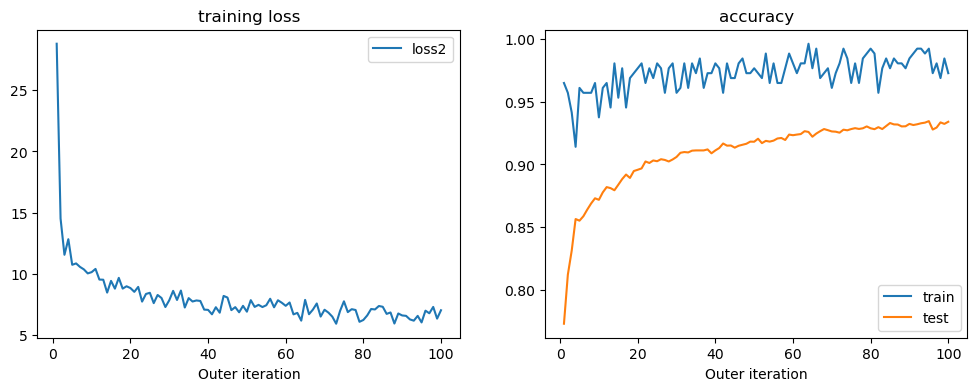

In [64]:
# Load results from file
save_path = '../results/bcd_b256_o100_i15.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results, xlabel='Outer iteration')

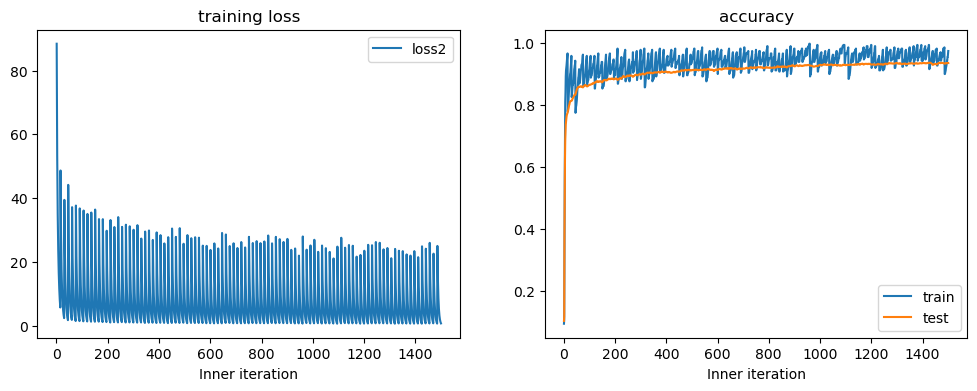

In [63]:
# Load results from file
save_path = '../results/bcd_b256_o100_i15_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='Inner iteration')

In [71]:
K = 10
batch_size = 256
num_iter = 150
niter_inner = 10
save_path = '../results/bcd_b256_o150_i10'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=10)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 10 
 - time: 1.1399998664855957 - sq_loss: 12.76744270324707 - tot_loss: 13.78149071237931 - acc: 0.90625 - val_acc: 0.7581
Inner Iter 10 / 10 
 - time: 1.0034966468811035 - sq_loss: 7.007214069366455 - tot_loss: 7.469832286533347 - acc: 0.8828125 - val_acc: 0.7982
Inner Iter 10 / 10 
 - time: 1.0024971961975098 - sq_loss: 5.250180721282959 - tot_loss: 5.542387557277834 - acc: 0.89453125 - val_acc: 0.8329
Inner Iter 10 / 10 
 - time: 0.9934971332550049 - sq_loss: 4.702290058135986 - tot_loss: 4.922079859101359 - acc: 0.91796875 - val_acc: 0.8588
Inner Iter 10 / 10 
 - time: 0.9894998073577881 - sq_loss: 4.633968353271484 - tot_loss: 4.821532585050591 - acc: 0.91015625 - val_acc: 0.8587
Inner Iter 10 / 10 
 - time: 0.9889957904815674 - sq_loss: 4.029558181762695 - tot_loss: 4.17438736065742 - acc: 0.91015625 - val_acc: 0.8634
Inner Iter 10 / 10 
 - time: 0.9934976100921631 - sq_loss: 4.005370616912842 - tot_loss: 4.14060283280196 - acc: 0.90234375 - val_acc: 0.8603
Inner

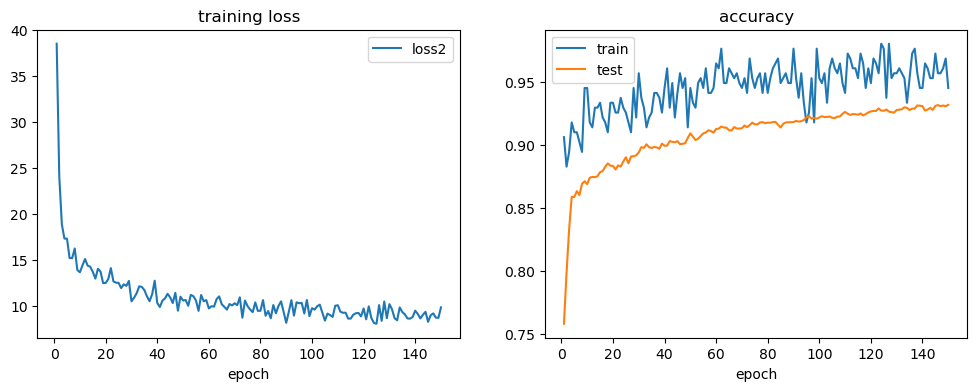

In [72]:
# Load results from file
save_path = '../results/bcd_b256_o150_i10.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

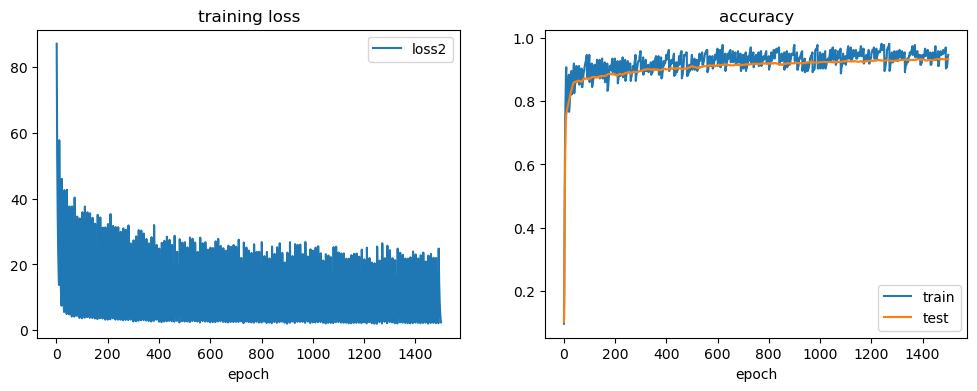

In [73]:
# Load results from file
save_path = '../results/bcd_b256_o150_i10_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner)

In [66]:
K = 10
batch_size = 256
num_iter = 50
niter_inner = 30
save_path = '../results/bcd_b256_o50_i30'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 30 
 - time: 1.018998622894287 - sq_loss: 12.723674774169922 - tot_loss: 13.73866508122046 - acc: 0.90234375 - val_acc: 0.7378
Inner Iter 20 / 30 
 - time: 2.0004992485046387 - sq_loss: 2.0047245025634766 - tot_loss: 2.3473473206395283 - acc: 0.98046875 - val_acc: 0.7783
Inner Iter 30 / 30 
 - time: 2.979041337966919 - sq_loss: 0.33817601203918457 - tot_loss: 0.4846649249084294 - acc: 1.0 - val_acc: 0.7768
Inner Iter 10 / 30 
 - time: 0.9769551753997803 - sq_loss: 5.038990020751953 - tot_loss: 5.22708942645113 - acc: 0.87109375 - val_acc: 0.7937
Inner Iter 20 / 30 
 - time: 1.9530298709869385 - sq_loss: 0.692129373550415 - tot_loss: 0.8538317353522871 - acc: 0.95703125 - val_acc: 0.7985
Inner Iter 30 / 30 
 - time: 2.937030792236328 - sq_loss: 0.13354289531707764 - tot_loss: 0.22506347816670313 - acc: 1.0 - val_acc: 0.7878
Inner Iter 10 / 30 
 - time: 0.9840404987335205 - sq_loss: 4.7873735427856445 - tot_loss: 4.90622286285361 - acc: 0.89453125 - val_acc: 0.8044
Inner 

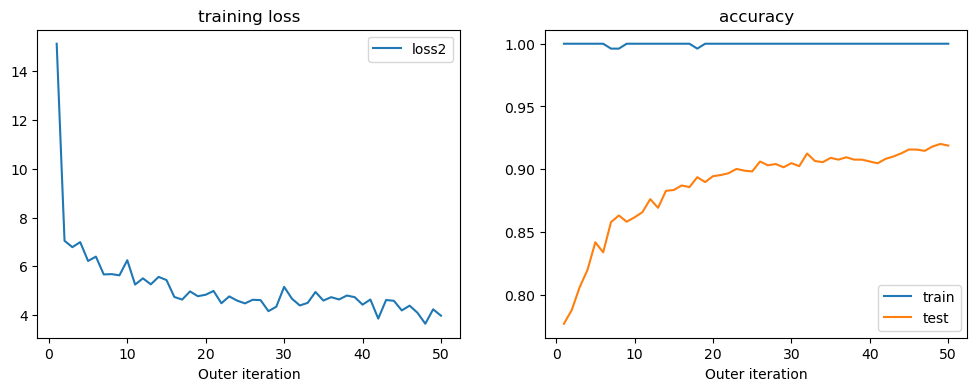

In [68]:
# Load results from file
save_path = '../results/bcd_b256_o50_i30.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results, xlabel='Outer iteration')

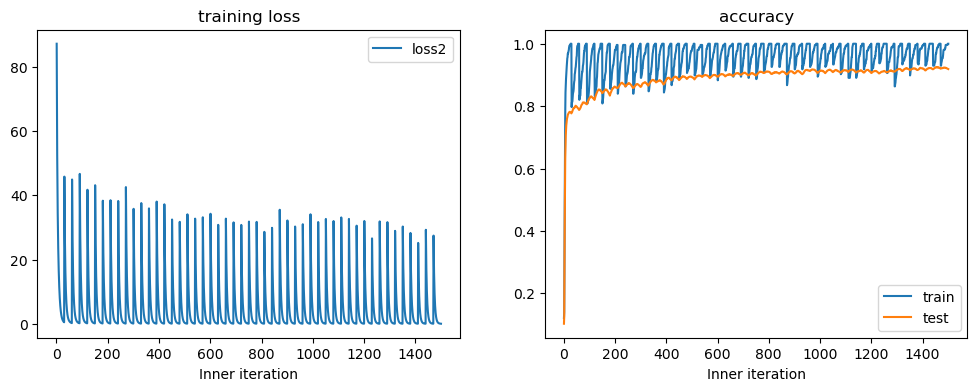

In [69]:
# Load results from file
save_path = '../results/bcd_b256_o50_i30_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='Inner iteration')

In [57]:
K = 10
batch_size = 256
num_iter = 10
niter_inner = 150
save_path = '../results/bcd_b256_o10_i150'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 150 
 - time: 1.2244622707366943 - sq_loss: 12.887149810791016 - tot_loss: 13.929978573773042 - acc: 0.9140625 - val_acc: 0.7686
Inner Iter 20 / 150 
 - time: 2.2199196815490723 - sq_loss: 2.038872480392456 - tot_loss: 2.3863755230850074 - acc: 0.98828125 - val_acc: 0.7975
Inner Iter 30 / 150 
 - time: 3.2184576988220215 - sq_loss: 0.3431750535964966 - tot_loss: 0.48649374447995797 - acc: 1.0 - val_acc: 0.7873
Inner Iter 40 / 150 
 - time: 4.214958667755127 - sq_loss: 0.07158297300338745 - tot_loss: 0.13746695237932727 - acc: 1.0 - val_acc: 0.7777
Inner Iter 50 / 150 
 - time: 5.2069995403289795 - sq_loss: 0.019896933808922768 - tot_loss: 0.05283696250990033 - acc: 1.0 - val_acc: 0.7668
Inner Iter 60 / 150 
 - time: 6.2014594078063965 - sq_loss: 0.007209728471934795 - tot_loss: 0.024852096452377737 - acc: 1.0 - val_acc: 0.7541
Inner Iter 70 / 150 
 - time: 7.193920612335205 - sq_loss: 0.0031528889667242765 - tot_loss: 0.013163754221750423 - acc: 1.0 - val_acc: 0.7473
In

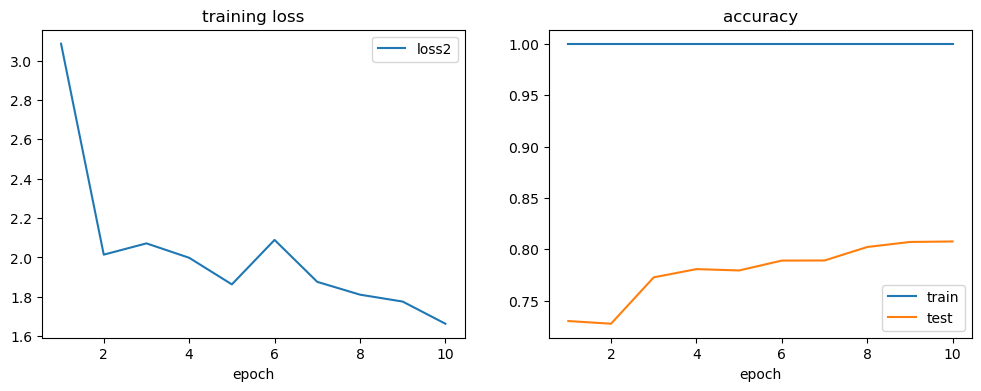

In [58]:
# Load results from file
save_path = '../results/bcd_b256_o10_i150.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

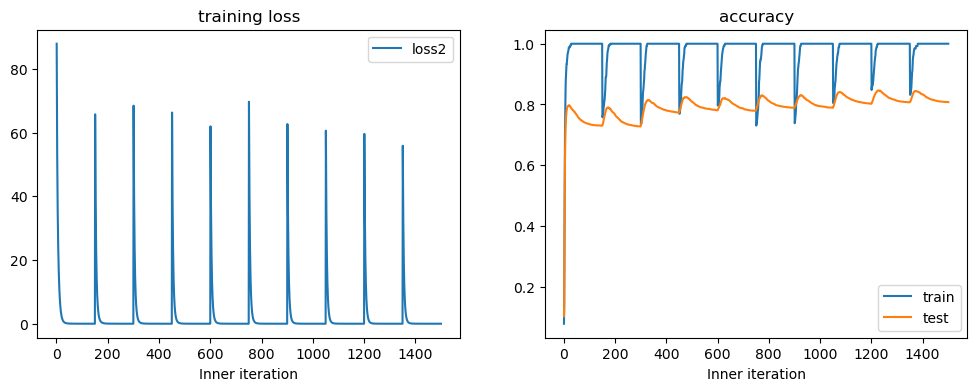

In [59]:
# Load results from file
save_path = '../results/bcd_b256_o10_i150_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='Inner iteration')

In [95]:
K = 10
batch_size = 512
num_iter = 3
niter_inner = 250
save_path = '../results/bcd_b512_o3_i250'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 250 
 - time: 1.2170014381408691 - sq_loss: 23.146713256835938 - tot_loss: 24.24802228109911 - acc: 0.912109375 - val_acc: 0.8184
Inner Iter 20 / 250 
 - time: 2.289497137069702 - sq_loss: 2.9424808025360107 - tot_loss: 3.3810212209355086 - acc: 0.98046875 - val_acc: 0.8401
Inner Iter 30 / 250 
 - time: 3.373995780944824 - sq_loss: 0.416485995054245 - tot_loss: 0.6183436899445951 - acc: 1.0 - val_acc: 0.8366
Inner Iter 40 / 250 
 - time: 4.429494142532349 - sq_loss: 0.07608426362276077 - tot_loss: 0.18266579927876592 - acc: 1.0 - val_acc: 0.8286
Inner Iter 50 / 250 
 - time: 5.490992784500122 - sq_loss: 0.01967514678835869 - tot_loss: 0.08268278883770108 - acc: 1.0 - val_acc: 0.819
Inner Iter 60 / 250 
 - time: 6.567992925643921 - sq_loss: 0.007070499937981367 - tot_loss: 0.047756911255419254 - acc: 1.0 - val_acc: 0.8125
Inner Iter 70 / 250 
 - time: 7.622493267059326 - sq_loss: 0.0032288189977407455 - tot_loss: 0.03132037096656859 - acc: 1.0 - val_acc: 0.8078
Inner Ite

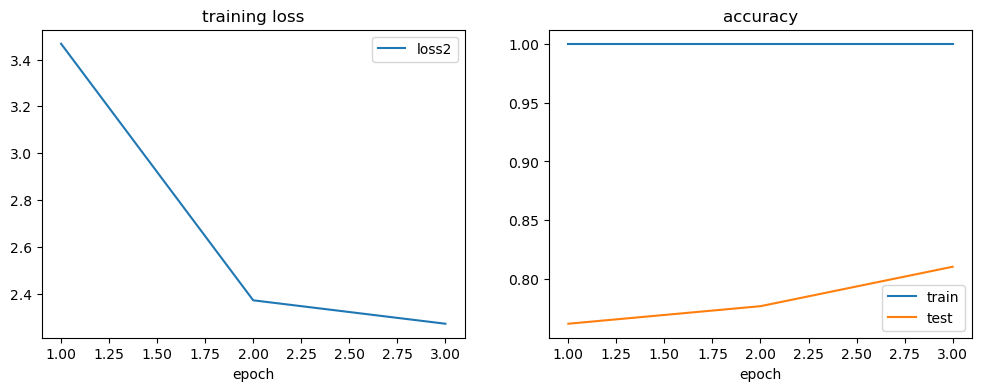

In [88]:
# Load results from file
save_path = '../results/bcd_b512_o3_i250.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

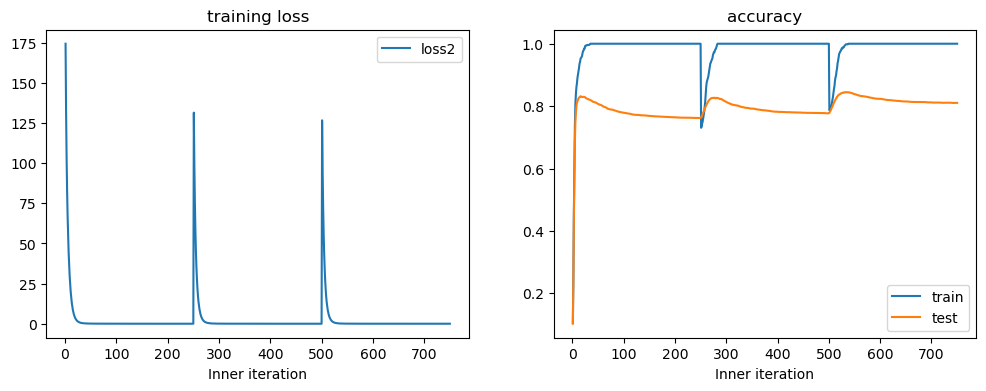

In [89]:
# Load results from file
save_path = '../results/bcd_b512_o3_i250_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='Inner iteration')

In [90]:
K = 10
batch_size = 512
num_iter = 30
niter_inner = 25
save_path = '../results/bcd_b512_o30_i25'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 25 
 - time: 1.3164927959442139 - sq_loss: 23.181955337524414 - tot_loss: 24.27547681311262 - acc: 0.912109375 - val_acc: 0.8113
Inner Iter 20 / 25 
 - time: 2.402491331100464 - sq_loss: 2.937164545059204 - tot_loss: 3.3747728888411075 - acc: 0.970703125 - val_acc: 0.8301
Inner Iter 10 / 25 
 - time: 1.099463939666748 - sq_loss: 8.710169792175293 - tot_loss: 8.943990001513157 - acc: 0.892578125 - val_acc: 0.8521
Inner Iter 20 / 25 
 - time: 2.1649649143218994 - sq_loss: 1.0596293210983276 - tot_loss: 1.2785729342140257 - acc: 0.966796875 - val_acc: 0.8616
Inner Iter 10 / 25 
 - time: 1.0624969005584717 - sq_loss: 7.686379909515381 - tot_loss: 7.818998925431515 - acc: 0.90625 - val_acc: 0.8701
Inner Iter 20 / 25 
 - time: 2.123994827270508 - sq_loss: 0.8649924397468567 - tot_loss: 1.0063118105754256 - acc: 0.9609375 - val_acc: 0.873
Inner Iter 10 / 25 
 - time: 1.0647499561309814 - sq_loss: 7.294649600982666 - tot_loss: 7.384951125117368 - acc: 0.91015625 - val_acc: 0.88

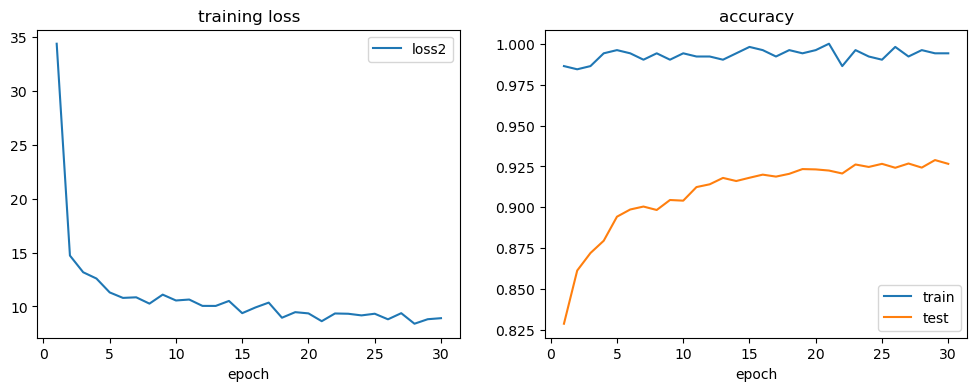

In [91]:
# Load results from file
save_path = '../results/bcd_b512_o30_i25.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

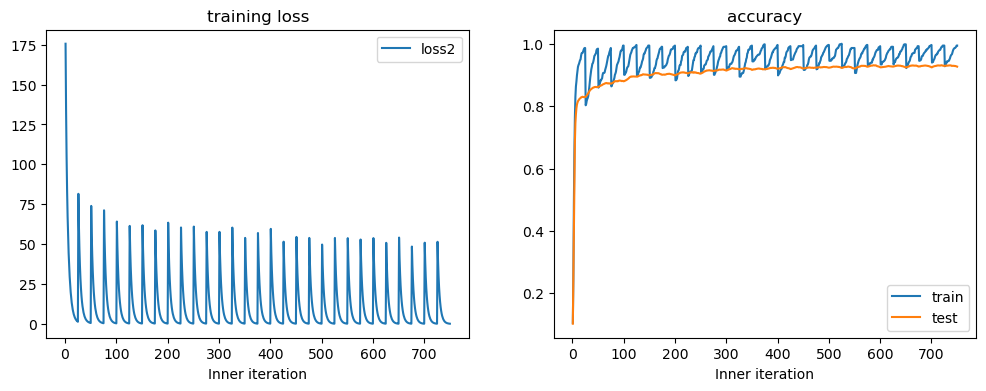

In [92]:
# Load results from file
save_path = '../results/bcd_b512_o30_i25_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='Inner iteration')

In [96]:
K = 10
batch_size = 1024
num_iter = 5
niter_inner = 75
save_path = '../results/bcd_b1024_o5_i75'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 75 
 - time: 1.3509981632232666 - sq_loss: 42.54566955566406 - tot_loss: 43.83384449139703 - acc: 0.900390625 - val_acc: 0.8345
Inner Iter 20 / 75 
 - time: 2.5350396633148193 - sq_loss: 4.613984107971191 - tot_loss: 5.145410002209246 - acc: 0.9736328125 - val_acc: 0.8551
Inner Iter 30 / 75 
 - time: 3.7105367183685303 - sq_loss: 0.5557637810707092 - tot_loss: 0.8216750808060169 - acc: 0.9951171875 - val_acc: 0.856
Inner Iter 40 / 75 
 - time: 4.8765339851379395 - sq_loss: 0.08434068411588669 - tot_loss: 0.24749238695949316 - acc: 0.9970703125 - val_acc: 0.8536
Inner Iter 50 / 75 
 - time: 6.0404932498931885 - sq_loss: 0.018460068851709366 - tot_loss: 0.1322307256050408 - acc: 0.9990234375 - val_acc: 0.8513
Inner Iter 60 / 75 
 - time: 7.194990873336792 - sq_loss: 0.006148587912321091 - tot_loss: 0.0917538134381175 - acc: 0.9990234375 - val_acc: 0.8484
Inner Iter 70 / 75 
 - time: 8.349491357803345 - sq_loss: 0.0028784789610654116 - tot_loss: 0.07040332292672247 - acc: 

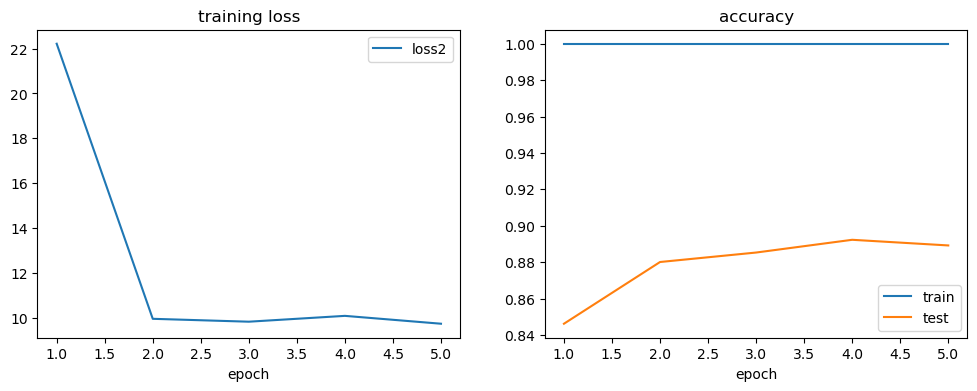

In [97]:
# Load results from file
save_path = '../results/bcd_b1024_o5_i75.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

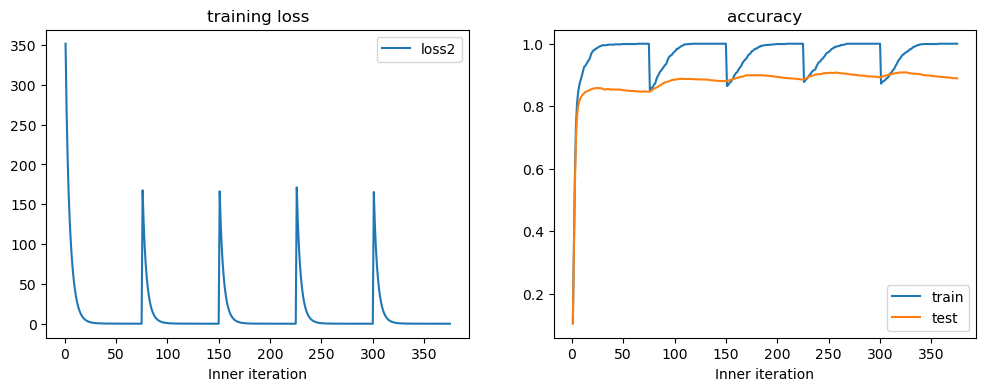

In [98]:
# Load results from file
save_path = '../results/bcd_b1024_o5_i75_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='Inner iteration')

In [99]:
K = 10
batch_size = 1024
num_iter = 15
niter_inner = 25
save_path = '../results/bcd_b1024_o15_i25'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 25 
 - time: 1.307497501373291 - sq_loss: 42.51054382324219 - tot_loss: 43.795052856672555 - acc: 0.9033203125 - val_acc: 0.8565
Inner Iter 20 / 25 
 - time: 2.450497627258301 - sq_loss: 4.610174655914307 - tot_loss: 5.143328573554754 - acc: 0.9658203125 - val_acc: 0.8722
Inner Iter 10 / 25 
 - time: 1.1229610443115234 - sq_loss: 14.151228904724121 - tot_loss: 14.368646031827666 - acc: 0.91015625 - val_acc: 0.8815
Inner Iter 20 / 25 
 - time: 2.1974213123321533 - sq_loss: 1.5125840902328491 - tot_loss: 1.7442423258908093 - acc: 0.9609375 - val_acc: 0.889
Inner Iter 10 / 25 
 - time: 1.077500581741333 - sq_loss: 12.985556602478027 - tot_loss: 13.111122277507093 - acc: 0.9140625 - val_acc: 0.8961
Inner Iter 20 / 25 
 - time: 2.1534998416900635 - sq_loss: 1.3139307498931885 - tot_loss: 1.4668998294509947 - acc: 0.958984375 - val_acc: 0.8981
Inner Iter 10 / 25 
 - time: 1.0869555473327637 - sq_loss: 11.772466659545898 - tot_loss: 11.858988305699313 - acc: 0.92578125 - val_a

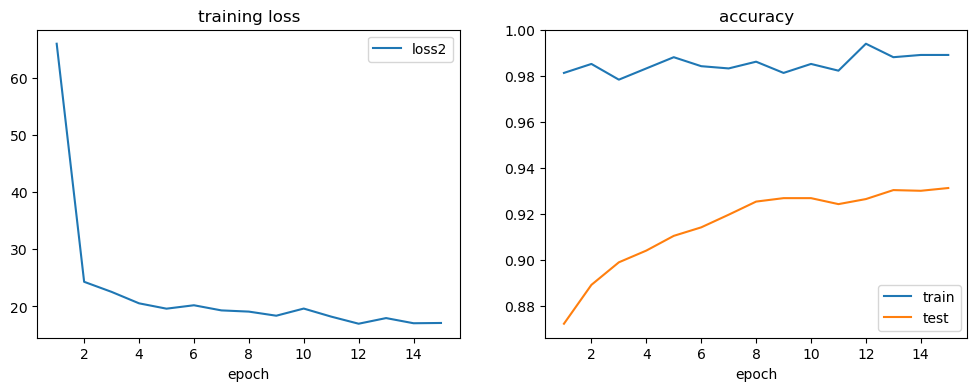

In [100]:
# Load results from file
save_path = '../results/bcd_b1024_o15_i25.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

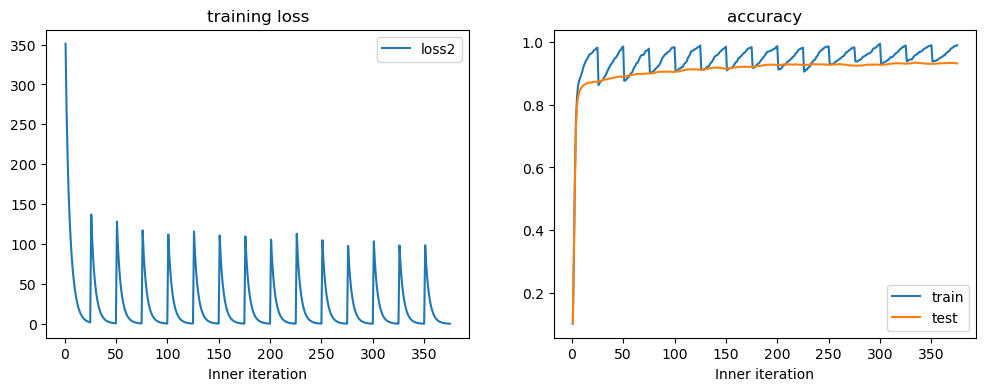

In [101]:
#  Load results from file
save_path = '../results/bcd_b1024_o15_i25_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='Inner iteration')

In [118]:
K = 10
batch_size = 2048
num_iter = 18
niter_inner = 10
save_path = '../results/bcd_b2048_o18_i10'

runner = ThreeSplitBCD((x_train, y_train), 
                       (x_test, y_test), 
                       K=K, 
                       batch_size=batch_size, 
                       device='cuda', 
                       hidden_sizes=None, 
                       depth=3,
                       seed=42)

results,inner = runner.train(niter=num_iter, niter_inner=niter_inner, log_inner=True, shuffle=True, verbose=5)

# Save results
with open(save_path+'.json', 'w') as f:
    json.dump(results, f)
with open(save_path+'_inner.json', 'w') as f:
    json.dump(inner, f)

Inner Iter 10 / 10 
 - time: 1.5980010032653809 - sq_loss: 79.19112396240234 - tot_loss: 80.7130646132864 - acc: 0.91650390625 - val_acc: 0.8733
Inner Iter 10 / 10 
 - time: 1.3544998168945312 - sq_loss: 34.76972961425781 - tot_loss: 35.395244429353625 - acc: 0.8994140625 - val_acc: 0.888
Inner Iter 10 / 10 
 - time: 1.3129971027374268 - sq_loss: 27.10557746887207 - tot_loss: 27.476782363897655 - acc: 0.90283203125 - val_acc: 0.8983
Inner Iter 10 / 10 
 - time: 1.2999985218048096 - sq_loss: 24.512908935546875 - tot_loss: 24.777757847565226 - acc: 0.90771484375 - val_acc: 0.9031
Inner Iter 10 / 10 
 - time: 1.3000001907348633 - sq_loss: 22.423099517822266 - tot_loss: 22.624329067592043 - acc: 0.91455078125 - val_acc: 0.907
Iter 5 / 18 
 - time: 1.3000001907348633 - sq_loss: 90.20894279479981 - tot_loss: 90.30121225073142 - acc: 0.91455078125 - val_acc: 0.907
Inner Iter 10 / 10 
 - time: 1.293499231338501 - sq_loss: 21.418865203857422 - tot_loss: 21.58301666608895 - acc: 0.93115234375 - 

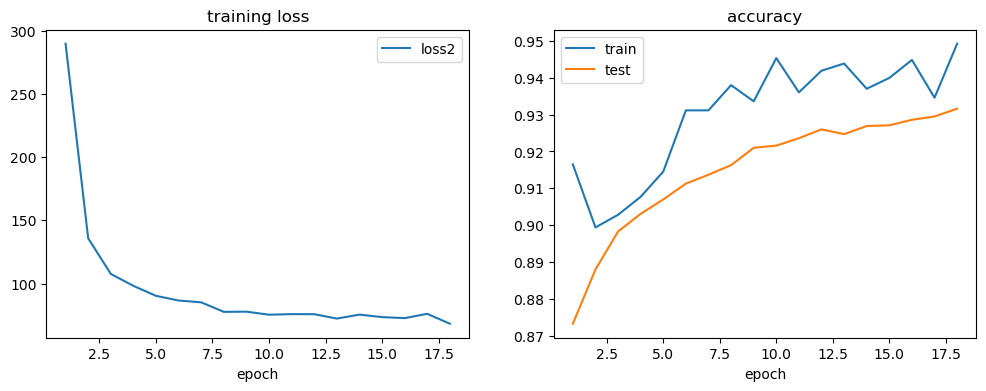

In [119]:
# Load results from file
save_path = '../results/bcd_b2048_o18_i10.json'
with open(save_path, 'r') as f:
    results = json.load(f)
plot_results_bcd(results)

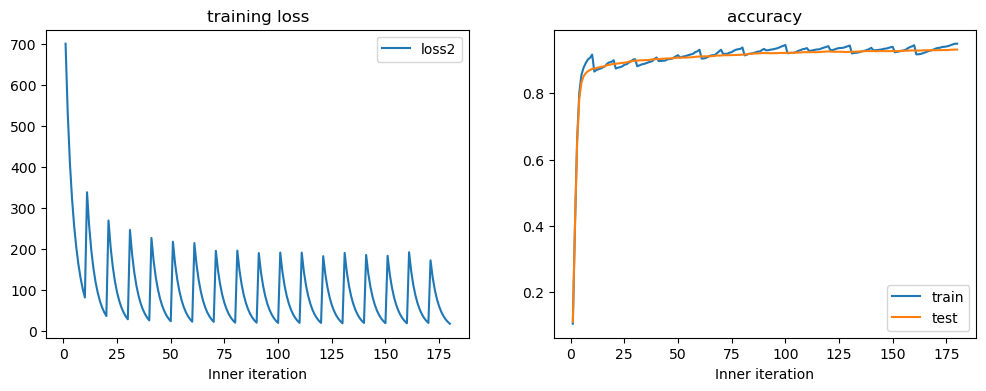

In [120]:
# Load results from file
save_path = '../results/bcd_b2048_o18_i10_inner.json'
with open(save_path, 'r') as f:
    inner = json.load(f)
plot_results_bcd(inner, xlabel='Inner iteration')

## Gradient Descent

In [5]:
from torch.optim import SGD, Adam
from gd import GDStandard

gd_runner = GDStandard((x_train,y_train), (x_test,y_test), K=10, batch_size=64, OptimClass=Adam, lr=3e-4, device=device, seed=42)
results_adam = gd_runner.train(50)
save_path = '../results/adam_b64_lr3e-4.json'
# Save results
with open(save_path, 'w') as f:
    json.dump(results_adam, f)

Epoch 1/50: Train Loss: 0.0342, Train Acc: 0.7231, Test Loss: 0.0341, Test Acc: 0.8042
Epoch 2/50: Train Loss: 0.0339, Train Acc: 0.8149, Test Loss: 0.0340, Test Acc: 0.8422
Epoch 3/50: Train Loss: 0.0339, Train Acc: 0.8455, Test Loss: 0.0340, Test Acc: 0.8698
Epoch 4/50: Train Loss: 0.0339, Train Acc: 0.8641, Test Loss: 0.0340, Test Acc: 0.8804
Epoch 5/50: Train Loss: 0.0339, Train Acc: 0.8770, Test Loss: 0.0340, Test Acc: 0.8937
Epoch 6/50: Train Loss: 0.0339, Train Acc: 0.8861, Test Loss: 0.0340, Test Acc: 0.8994
Epoch 7/50: Train Loss: 0.0339, Train Acc: 0.8948, Test Loss: 0.0340, Test Acc: 0.9042
Epoch 8/50: Train Loss: 0.0339, Train Acc: 0.9010, Test Loss: 0.0340, Test Acc: 0.9095
Epoch 9/50: Train Loss: 0.0339, Train Acc: 0.9047, Test Loss: 0.0340, Test Acc: 0.9121
Epoch 10/50: Train Loss: 0.0339, Train Acc: 0.9087, Test Loss: 0.0340, Test Acc: 0.9085
Epoch 11/50: Train Loss: 0.0339, Train Acc: 0.9141, Test Loss: 0.0340, Test Acc: 0.9227
Epoch 12/50: Train Loss: 0.0338, Train Ac

FileNotFoundError: [Errno 2] No such file or directory: '../results/adam_b64_lr3e-4.json'

In [14]:
from torch.optim import SGD

optim_args = {'lr': 1e-1, 'momentum': 0.9}
gd_runner = GDStandard((x_train,y_train), (x_test,y_test), K=10, batch_size=64, OptimClass=SGD, optim_args=optim_args, device=device, seed=42)
results_momentum = gd_runner.train(50)
save_path = '../results/momentum9_b64_lr1e-1.json'
# Save results
with open(save_path, 'w') as f:
    json.dump(results_momentum, f)

Epoch 1/50: Train Loss: 0.0355, Train Acc: 0.4341, Test Loss: 0.0343, Test Acc: 0.6291
Epoch 2/50: Train Loss: 0.0340, Train Acc: 0.7456, Test Loss: 0.0341, Test Acc: 0.7937
Epoch 3/50: Train Loss: 0.0339, Train Acc: 0.8137, Test Loss: 0.0340, Test Acc: 0.8410
Epoch 4/50: Train Loss: 0.0339, Train Acc: 0.8387, Test Loss: 0.0340, Test Acc: 0.8556
Epoch 5/50: Train Loss: 0.0339, Train Acc: 0.8586, Test Loss: 0.0340, Test Acc: 0.8735
Epoch 6/50: Train Loss: 0.0339, Train Acc: 0.8700, Test Loss: 0.0340, Test Acc: 0.8861
Epoch 7/50: Train Loss: 0.0339, Train Acc: 0.8817, Test Loss: 0.0340, Test Acc: 0.8899
Epoch 8/50: Train Loss: 0.0339, Train Acc: 0.8863, Test Loss: 0.0340, Test Acc: 0.8964
Epoch 9/50: Train Loss: 0.0339, Train Acc: 0.8931, Test Loss: 0.0340, Test Acc: 0.8930
Epoch 10/50: Train Loss: 0.0339, Train Acc: 0.8969, Test Loss: 0.0340, Test Acc: 0.9039
Epoch 11/50: Train Loss: 0.0339, Train Acc: 0.8998, Test Loss: 0.0340, Test Acc: 0.9069
Epoch 12/50: Train Loss: 0.0339, Train Ac

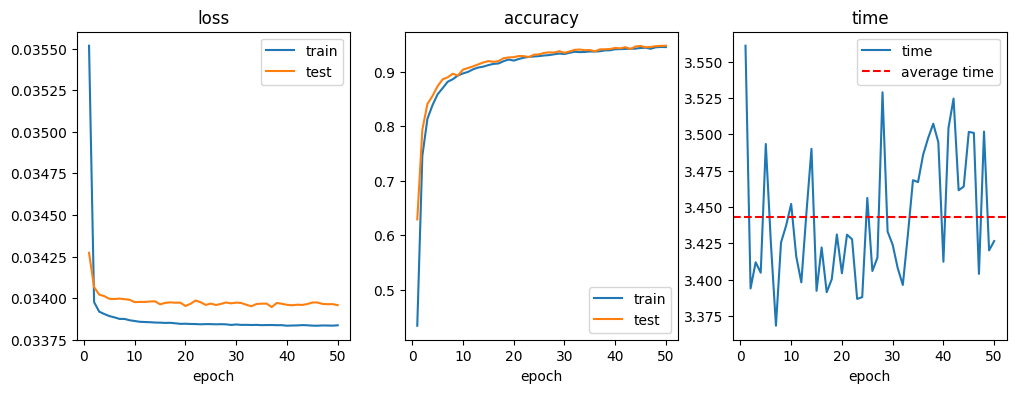

In [15]:
from utils import plot_results

plot_results(results_momentum)
plt.show()

### RMSprop

In [17]:
from torch.optim import RMSprop

optim_args = {'lr': 1e-3}
gd_runner = GDStandard((x_train,y_train), (x_test,y_test), K=10, batch_size=64, OptimClass=RMSprop, optim_args=optim_args, device=device, seed=42)
results = gd_runner.train(50)
save_path = '../results/RMSprop_b64_lr1e-3.json'
# Save results
with open(save_path, 'w') as f:
    json.dump(results, f)

Epoch 1/50: Train Loss: 0.0340, Train Acc: 0.7820, Test Loss: 0.0340, Test Acc: 0.8405
Epoch 2/50: Train Loss: 0.0339, Train Acc: 0.8672, Test Loss: 0.0340, Test Acc: 0.8937
Epoch 3/50: Train Loss: 0.0339, Train Acc: 0.8950, Test Loss: 0.0340, Test Acc: 0.9040
Epoch 4/50: Train Loss: 0.0339, Train Acc: 0.9088, Test Loss: 0.0340, Test Acc: 0.9196
Epoch 5/50: Train Loss: 0.0338, Train Acc: 0.9182, Test Loss: 0.0340, Test Acc: 0.9259
Epoch 6/50: Train Loss: 0.0338, Train Acc: 0.9234, Test Loss: 0.0340, Test Acc: 0.9326
Epoch 7/50: Train Loss: 0.0338, Train Acc: 0.9300, Test Loss: 0.0340, Test Acc: 0.9284
Epoch 8/50: Train Loss: 0.0338, Train Acc: 0.9322, Test Loss: 0.0340, Test Acc: 0.9377
Epoch 9/50: Train Loss: 0.0338, Train Acc: 0.9365, Test Loss: 0.0340, Test Acc: 0.9409
Epoch 10/50: Train Loss: 0.0338, Train Acc: 0.9405, Test Loss: 0.0340, Test Acc: 0.9365
Epoch 11/50: Train Loss: 0.0338, Train Acc: 0.9437, Test Loss: 0.0340, Test Acc: 0.9419
Epoch 12/50: Train Loss: 0.0338, Train Ac

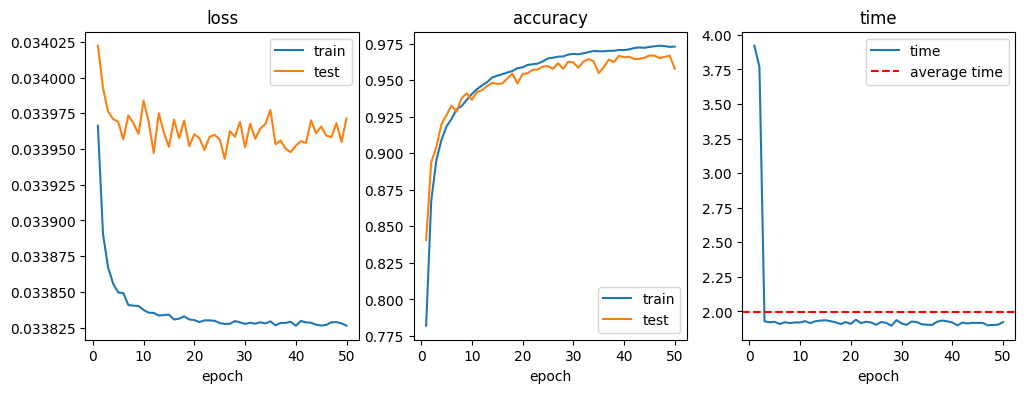

In [18]:
plot_results(results)
plt.show()